In [1]:
import json
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader

# Load dataset (assumed CSV format for peer reviews)
# Reading review with aspect JSONL file
data = pd.read_json(r'review_with_aspect.jsonl', lines=True)

In [2]:
from torch.optim import AdamW

In [3]:
import json
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Load JSONL data from file (one JSON object per line)
data = []

with open('review_with_aspect.jsonl', 'r') as file:  # Replace 'review_with_aspect.jsonl' with your actual file path
    for line in file:
        # Parse each line (JSON object) and append it to the data list
        data.append(json.loads(line))

# Check the first entry to ensure it loaded correctly
print(data[0])  # Example to check the first review

# Define the aspect labels (you should include all the possible aspect labels here)
aspect_labels = [
    "summary", "motivation_positive", "clarity_positive", "soundness_negative",
    "substance_negative", "meaningful_comparison_negative", "soundness_negative",
    "substance_positive", "clarity_negative", "originality_positive", "originality_negative",
    "replicability_negative", "soundness_positive", "replicability_positive",
    "motivation_negative", "clarity_positive"
]

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Custom Dataset for Multi-Label Classification
class ReviewDataset(Dataset):
    def __init__(self, reviews, aspect_labels, tokenizer, max_len):
        self.reviews = reviews
        self.aspect_labels = aspect_labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.aspect_labels[idx]

        # Tokenize the review text
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Convert aspect labels (True/False) to tensor for multi-label classification
        labels = torch.tensor(label, dtype=torch.float)

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': labels
        }

# Prepare the data: create a binary vector for each aspect (1 for presence, 0 for absence)
def prepare_data(data):
    reviews = []
    aspect_vectors = []

    for entry in data:
        text = entry['text']
        labels = entry['labels']

        # Initialize aspect vector with 0 (False)
        aspect_vector = [0] * len(aspect_labels)

        # Mark aspects present in the review
        for label in labels:
            aspect_name = label[2]
            if aspect_name in aspect_labels:
                index = aspect_labels.index(aspect_name)
                aspect_vector[index] = 1  # Aspect is present

        reviews.append(text)
        aspect_vectors.append(aspect_vector)

    return reviews, aspect_vectors

# Prepare data
reviews, aspect_vectors = prepare_data(data)

{'id': 'ICLR_2020_1123', 'text': "This work studies the predictive uncertainty issue of deep learning models . In particular , this work focuses on the distributional uncertainty which is caused by distributional mismatch between training and test examples . The proposed method is developed based on the existing work called Dirichlet Prior Network ( DPN ) . It aims to address the issue of DPN that its loss function is complicated and makes the optimization difficult . Instead , this paper proposes a new loss function for DPN , which consists of the commonly used cross-entropy loss term and a regularization term . Two loss functions are respectively defined over in-domain training examples and out-of-distribution ( OOD ) training examples . The final objective function is a weighted combination of the two loss functions . Experimental study is conducted on one synthetic dataset and two image datasets ( CIFAR-10 and CIFAR-100 ) to demonstrate the properties of the proposed method and com

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [4]:
#!pip install captum

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# First Split: Split data into training (70%) and validation (30%) sets
X_train, X_val, y_train, y_val = train_test_split(reviews, aspect_vectors, test_size=0.3, random_state=42)

# Second Split: Split validation set into validation (66%) and test (34%) sets (for 20% test out of the original data)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# Parameters
max_len = 512
batch_size = 8

# Create DataLoader for training, validation, and testing
train_dataset = ReviewDataset(X_train, y_train, tokenizer, max_len)
val_dataset = ReviewDataset(X_val, y_val, tokenizer, max_len)
test_dataset = ReviewDataset(X_test, y_test, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kaan-topcu (topcu-kaan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
Train Loss: 0.3690, Train Accuracy: 0.8259
Validation Loss: 0.2920, Validation Accuracy: 0.8720
Epoch 2/20
Train Loss: 0.2546, Train Accuracy: 0.8907
Validation Loss: 0.2493, Validation Accuracy: 0.8974
Epoch 3/20
Train Loss: 0.1985, Train Accuracy: 0.9198
Validation Loss: 0.2568, Validation Accuracy: 0.9003
Epoch 4/20
Train Loss: 0.1571, Train Accuracy: 0.9398
Validation Loss: 0.2719, Validation Accuracy: 0.8981
Early stopping triggered. Stopping training.


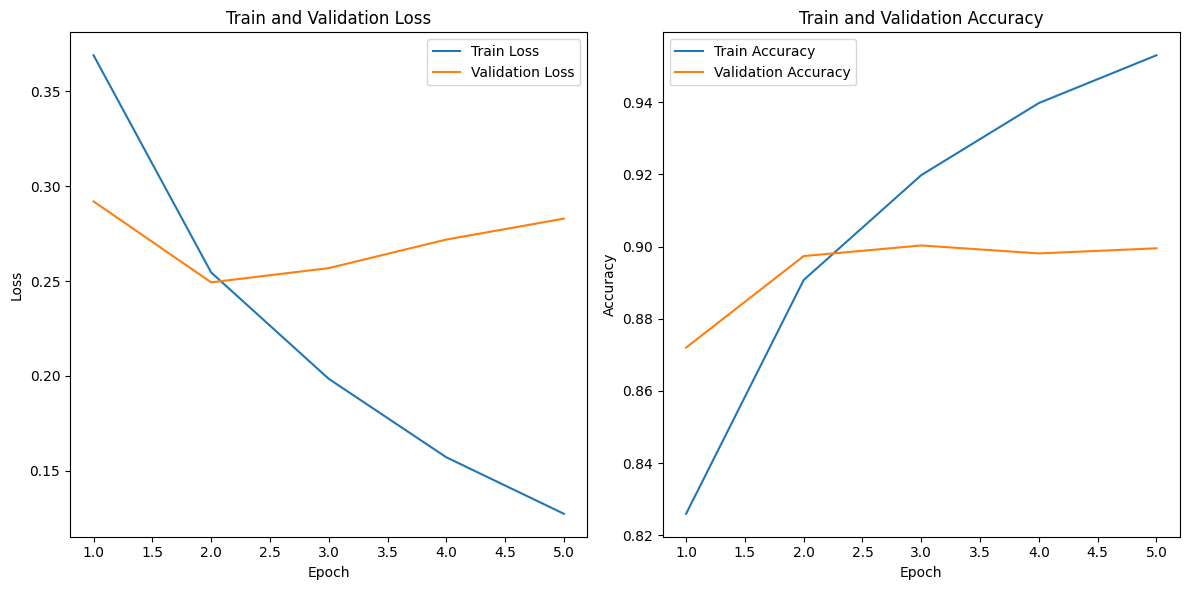

['/content/wandb/run-20250624_152955-vcj9z9vg/files/final_model.pth']

In [6]:
import wandb
import torch
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification

# Initialize W&B
wandb.init(project="aspect-based-sentiment-analysis", entity="topcu-kaan")  # Replace with your actual username and project name

# Hyperparameters
epochs = 20
batch_size = 8
learning_rate = 2e-5
patience = 3  # Early stopping patience

# Log hyperparameters to W&B
wandb.config.update({
    "epochs": epochs,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "patience": patience
})

# Load pre-trained BERT model for multi-label classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(aspect_labels))

# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Training loop with validation and early stopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Store the training and validation loss/accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Early stopping parameters
best_val_loss = float('inf')
counter = 0

# Number of epochs
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    correct_train_preds = 0
    total_train_preds = 0

    # Training phase
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        # Calculate accuracy for training
        logits = outputs.logits
        preds = (logits > 0.5).float()  # Apply threshold
        correct_train_preds += (preds == labels).sum().item()
        total_train_preds += labels.numel()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train_preds / total_train_preds

    # Validation phase
    model.eval()
    total_val_loss = 0
    correct_val_preds = 0
    total_val_preds = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            # Calculate accuracy for validation
            logits = outputs.logits
            preds = (logits > 0.5).float()  # Apply threshold
            correct_val_preds += (preds == labels).sum().item()
            total_val_preds += labels.numel()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val_preds / total_val_preds

    # Store values for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Log to W&B
    wandb.log({
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "train_accuracy": train_accuracy,
        "val_accuracy": val_accuracy,
        "epoch": epoch + 1
    })

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting training and validation loss/accuracy
plt.figure(figsize=(12, 6))

# Plot train and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Plot train and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Save the final model
torch.save(model.state_dict(), "final_model.pth")

# Save the model to W&B
wandb.save("final_model.pth")


In [7]:
"""
import torch
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification

# Hyperparameters
epochs = 20
batch_size = 8
learning_rate = 2e-5
patience = 3  # Early stopping patience

# Load pre-trained BERT model for multi-label classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(aspect_labels))

# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Training loop with validation and early stopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Store the training and validation loss/accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Early stopping parameters
best_val_loss = float('inf')
counter = 0

# Number of epochs
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    correct_train_preds = 0
    total_train_preds = 0

    # Training phase
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        # Calculate accuracy for training
        logits = outputs.logits
        preds = (logits > 0.5).float()  # Apply threshold
        correct_train_preds += (preds == labels).sum().item()
        total_train_preds += labels.numel()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train_preds / total_train_preds

    # Validation phase
    model.eval()
    total_val_loss = 0
    correct_val_preds = 0
    total_val_preds = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            # Calculate accuracy for validation
            logits = outputs.logits
            preds = (logits > 0.5).float()  # Apply threshold
            correct_val_preds += (preds == labels).sum().item()
            total_val_preds += labels.numel()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val_preds / total_val_preds

    # Store values for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting training and validation loss/accuracy
plt.figure(figsize=(12, 6))

# Plot train and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Plot train and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Save the final model
torch.save(model.state_dict(), "final_model.pth")
"""

'\nimport torch\nfrom torch.optim import AdamW\nfrom sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score\nimport matplotlib.pyplot as plt\nimport numpy as np\nfrom transformers import BertTokenizer, BertForSequenceClassification\n\n# Hyperparameters\nepochs = 20\nbatch_size = 8\nlearning_rate = 2e-5\npatience = 3  # Early stopping patience\n\n# Load pre-trained BERT model for multi-label classification\nmodel = BertForSequenceClassification.from_pretrained(\'bert-base-uncased\', num_labels=len(aspect_labels))\n\n# Optimizer\noptimizer = AdamW(model.parameters(), lr=learning_rate)\n\n# Training loop with validation and early stopping\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel.to(device)\n\n# Store the training and validation loss/accuracy for plotting\ntrain_losses = []\nval_losses = []\ntrain_accuracies = []\nval_accuracies = []\n\n# Early stopping parameters\nbest_val_loss = float(\'inf\')\ncounter = 0\n\n# Number of epochs

In [8]:
#!pip install captum

In [25]:
import torch
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from transformers import BertTokenizer, BertForSequenceClassification

# Initialize BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Example text to explain (ensure it's a raw string)
sample_text = X_train[0]  # Sample text from your training data

# Tokenizing the sample text
tokens = tokenizer.encode(sample_text, return_tensors='pt')

# Ensure the tensor is of the correct type (Long) and moved to the correct device (GPU/CPU)
tokens = tokens.to(device)  # Move tokens to the same device as the model
tokens = tokens.long()  # Convert tokens to LongTensor (embedding layer requires LongTensor)

# Ensure tokens are of the correct type (Long) after moving them to the device
assert tokens.dtype == torch.long, "Tokens should be of type LongTensor"

# Initialize Integrated Gradients for interpretation
ig = IntegratedGradients(model)

# Explain the prediction for the sample
attributions, delta = ig.attribute(tokens, target=0, return_convergence_delta=True)  # Target index can be changed

# Visualize the attributions for the tokens
tokens = tokenizer.convert_ids_to_tokens(tokens[0].cpu().numpy())  # Convert token IDs to words
attributions = attributions[0].cpu().detach().numpy()  # Get the attribution values

# Plot the token attributions
plt.figure(figsize=(10, 6))
plt.barh(tokens, attributions)
plt.xlabel('Attribution Score')
plt.title('Integrated Gradients for Token Attribution')
plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)

In [ ]:
# Evaluation
model.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred = (logits > 0.5).cpu().numpy()  # Apply threshold (0.5) for multi-label classification
        predictions.extend(pred)
        true_labels.extend(labels.cpu().numpy())

# Evaluate metrics
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='micro')  # Micro F1 for multi-label classification

print(f"Test Accuracy: {accuracy}")
print(f"Test F1-Score: {f1}")

# Logistic Regression

In [29]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.multioutput import MultiOutputClassifier

# Assuming you have already extracted the reviews and aspect vectors as shown before

# Your list of unique aspect labels (you can use the ones you already extracted)
unique_labels = ['clarity_negative', 'clarity_positive', 'meaningful_comparison_negative', 'motivation_negative', 'motivation_positive',
                 'originality_negative', 'originality_positive', 'replicability_negative', 'replicability_positive', 'soundness_negative',
                 'soundness_positive', 'substance_negative', 'substance_positive', 'summary']



# Step 1: Extract reviews and labels
reviews = [entry["text"] for entry in data]
labels = [entry["labels"] for entry in data]

# Step 2: Create aspect vectors (binary vectors for each aspect)
def create_aspect_vectors(reviews, labels, aspect_labels):
    aspect_vectors = []

    for i, review in enumerate(reviews):
        # Initialize aspect vector for each review, all zeros initially
        aspect_vector = np.zeros(len(aspect_labels))

        # Iterate over the labels to mark the presence of each aspect
        for label in labels[i]:
            start, end, aspect = label
            # If the aspect is present in the review, mark it as 1 in the vector
            if aspect in aspect_labels:
                aspect_index = aspect_labels.index(aspect)
                aspect_vector[aspect_index] = 1

        aspect_vectors.append(aspect_vector)

    return aspect_vectors

# Generate aspect vectors
aspect_vectors = create_aspect_vectors(reviews, labels, unique_labels)

# Step 3: Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(reviews, aspect_vectors, test_size=0.2, random_state=42)

# Step 4: TF-IDF Vectorization (Convert the reviews into numerical data)
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Step 5: Train Logistic Regression model
# We'll use MultiOutputClassifier to handle multi-label classification (multiple aspects)
lr_model = LogisticRegression(max_iter=1000)

# MultiOutputClassifier allows us to train one Logistic Regression model for each aspect
multi_output_model = MultiOutputClassifier(lr_model, n_jobs=-1)

# Train the model
multi_output_model.fit(X_train_tfidf, y_train)

# Step 6: Predict and evaluate the model
y_train_pred = multi_output_model.predict(X_train_tfidf)
y_test_pred = multi_output_model.predict(X_test_tfidf)

# Step 7: Calculate evaluation metrics
# Accuracy for each aspect
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# F1 Score for each aspect
train_f1 = f1_score(y_train, y_train_pred, average='micro')
test_f1 = f1_score(y_test, y_test_pred, average='micro')

# Precision and Recall for each aspect
train_precision = precision_score(y_train, y_train_pred, average='micro')
test_precision = precision_score(y_test, y_test_pred, average='micro')

train_recall = recall_score(y_train, y_train_pred, average='micro')
test_recall = recall_score(y_test, y_test_pred, average='micro')

# Print the evaluation results
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Optionally, print individual aspect-wise performance
for i, aspect in enumerate(unique_labels):
    # Get the predictions and ground truth for the i-th aspect
    aspect_train_true = [y_train[j][i] for j in range(len(y_train))]
    aspect_train_pred = [y_train_pred[j][i] for j in range(len(y_train_pred))]

    aspect_test_true = [y_test[j][i] for j in range(len(y_test))]
    aspect_test_pred = [y_test_pred[j][i] for j in range(len(y_test_pred))]

    # Calculate accuracy for this aspect
    aspect_train_accuracy = accuracy_score(aspect_train_true, aspect_train_pred)
    aspect_test_accuracy = accuracy_score(aspect_test_true, aspect_test_pred)

    print(f"Aspect: {aspect}")
    print(f"  Train Accuracy: {aspect_train_accuracy:.4f}")
    print(f"  Test Accuracy: {aspect_test_accuracy:.4f}")


Train Accuracy: 0.0986
Test Accuracy: 0.0681
Train F1-Score: 0.7046
Test F1-Score: 0.6505
Train Precision: 0.8550
Test Precision: 0.7970
Train Recall: 0.5992
Test Recall: 0.5494
Aspect: clarity_negative
  Train Accuracy: 0.8041
  Test Accuracy: 0.7765
Aspect: clarity_positive
  Train Accuracy: 0.8612
  Test Accuracy: 0.8113
Aspect: meaningful_comparison_negative
  Train Accuracy: 0.8341
  Test Accuracy: 0.8147
Aspect: motivation_negative
  Train Accuracy: 0.8940
  Test Accuracy: 0.8894
Aspect: motivation_positive
  Train Accuracy: 0.7776
  Test Accuracy: 0.7376
Aspect: originality_negative
  Train Accuracy: 0.8321
  Test Accuracy: 0.8090
Aspect: originality_positive
  Train Accuracy: 0.7803
  Test Accuracy: 0.7326
Aspect: replicability_negative
  Train Accuracy: 0.8861
  Test Accuracy: 0.8750
Aspect: replicability_positive
  Train Accuracy: 0.9893
  Test Accuracy: 0.9921
Aspect: soundness_negative
  Train Accuracy: 0.7654
  Test Accuracy: 0.7132
Aspect: soundness_positive
  Train Accur

In [31]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0d667251fd037a0259dd16319311de46eea586cd5911d88326f2358d721d4f16
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
